<center><h1>Teste Efeito do lockdown em cursos EAD na Graduação</h1>
<h4>Por Beatriz Ottoboni</h4>


- <b>Descrição:</b> Verificar se com o lockdown causado pela pandemia do Covid-19 teve impacto no total de matrículas anuais em cusos EAD da graduação no Brasil.

- <b>Data de execução:</b> janeiro 2024
    
- <b>Dados utilizados:</b> Censo da Educação Superior/INEP dos anos de 2009 a 2022.

- <b>Metodologia de análise:</b> Inferência de impacto causal com modelo bayesiano de série temporal (referência: https://research.google/pubs/inferring-causal-impact-using-bayesian-structural-time-series-models/).


<h3>Sumário:<p>
<h4><b><a href='#biblioteca'>1. Bibliotecas</a><br>
<a href='#concatenar'>2. Concatenar dados</a><br>
<a href='#visualizar'>3. Visualização dos dados</a><br>
<a href='#modelos'>4. Teste de modelos de previsão</a><br>
<a href='#resultados'>5. Resultados</a><br>

<h3><a id='biblioteca'></a>1. Bibliotecas

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, log_loss, precision_recall_curve, auc, average_precision_score, recall_score
from causalimpact import CausalImpact
from causalimpact import plot

<h3><a id='concatenar'></a>2. Concatenar dados

In [2]:
#path = "senso_superior_microdados"
#files = os.listdir(path)

#df = pd.concat([pd.read_csv(f'{path}/{file}', sep=';', encoding="ISO-8859-1") for file in files])

#df[['NU_ANO_CENSO', 'TP_MODALIDADE_ENSINO', 'CO_UF', 'IN_CAPITAL', 'TP_REDE', 
#    'CO_CINE_AREA_GERAL', 'QT_MAT']].to_csv('censo_superior_2009_2022.csv', sep=';', index=False)

In [3]:
df = pd.read_csv('censo_superior_2009_2022.csv', sep=';')

<h3><a id='visualizar'></a>3. Visualização dos dados

In [4]:
df_group = (df.groupby(['NU_ANO_CENSO', 'TP_MODALIDADE_ENSINO'])
    .agg({'QT_MAT':sum}).reset_index())
df_group = df_group.pivot_table(index='NU_ANO_CENSO', columns=['TP_MODALIDADE_ENSINO'],  values=['QT_MAT'], fill_value=0)
df_group.columns=['PRESENCIAL','EAD']

display(df_group.shape)

(14, 2)

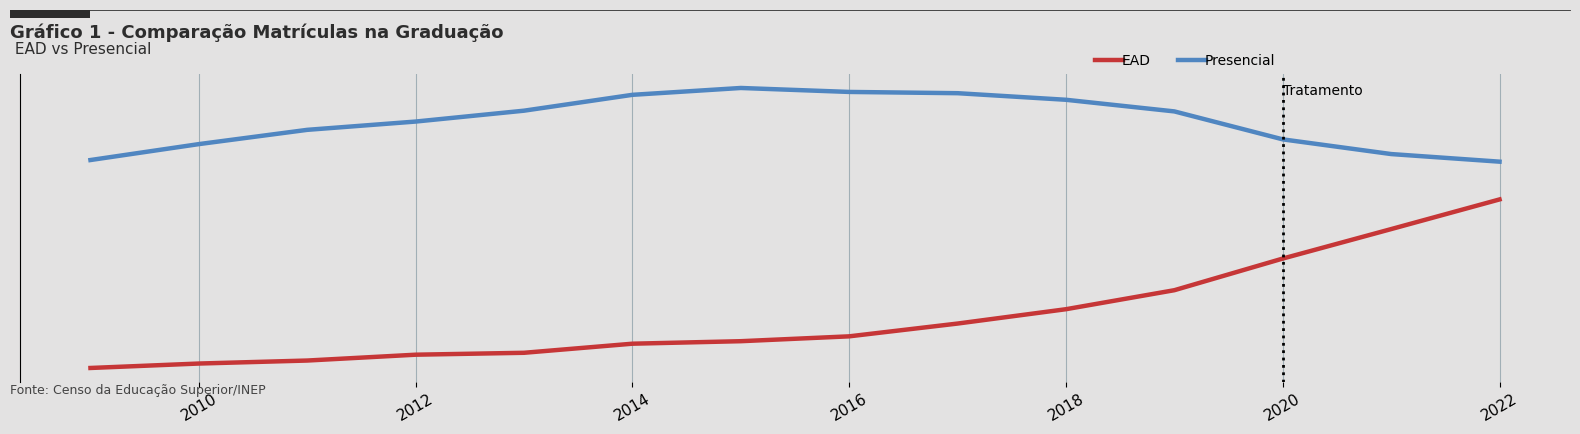

In [5]:

fig, ax = plt.subplots(figsize=(20,4), facecolor='#E3E2E2')

ax.grid(color='#758D99', alpha=0.6, zorder=1)

ax.set_facecolor('#E3E2E2')

# Plot data
ax.plot(df_group['EAD'], color='#C63637', alpha=1.0, linewidth=3.2)
ax.plot(df_group['PRESENCIAL'], color='#5086C1', alpha=1.0, linewidth=3.2)

ax.axvline(x=2020, ls=':', c='black', lw=2), plt.text(2020, 6500000, s='Tratamento', c='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=11)        # Set tick label size

ax.set_yticks(np.arange(0,10000,1000))
ax.set_yticklabels(np.arange(0, 10000, 1000),            
                   ha = 'right',                
                   verticalalignment='bottom')      

ax.yaxis.set_tick_params(pad=-2,             
                         labeltop=True,      
                         labelbottom=False,  
                         bottom=False,      
                         labelsize=11)      


ax.plot([0.12, .9],                  
        [1.04, 1.04],                 
        transform=fig.transFigure,   
        clip_on=False, 
        color='#2C2C2C', 
        linewidth=.6)

ax.add_patch(plt.Rectangle((0.12,1.04),                 
                           0.04,                 
                           -0.02,                      
                           facecolor='#2C2C2C', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

plt.xticks(rotation=30)

ax.text(x=0.12, y=0.97, s="Gráfico 1 - Comparação Matrículas na Graduação", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.93, s=" EAD vs Presencial", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

ax.legend(['EAD', 'Presencial'], loc=(.69,1.0), ncol=2, frameon=False, handletextpad=-.1, handleheight=1)

ax.text(x=0.12, y=0.08, s="""Fonte: Censo da Educação Superior/INEP """, transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show() 

O gráfico 1 mostra a evolução das matrículas em cursos presenciais e EAD entre 2009 e 2022. Nota-se que desde de 2015 já existia uma tendência de queda em cursos presenciais e aumento nos EAD, contudo após 2019 há uma acelaração nesse movimento. 

Com o início do lockdown em decorrência da pandemia de covid-19 no início de 2020, esse foi o ano considerado como tratamento.

<h3><a id='modelos'></a>4. Teste de modelos de previsão

O contrafactual utilizado para verificar se há efeito causal entre lockdown e cursos EAD será output do modelo que melhor prevê o total de matrículas em cursos EAD. 

As variáveis explicativas utilizadas foram matrículas em cursos presenciais, dummy de capital, dummy tipo de rede (pública e privada), dummy de área do conhecimento e dummy de unidade federativa.

Os modelos preditivos testados foram:<p>
<b><a href='#linear'>4.1. Regressão Linear</a><br>
<a href='#tree'>4.2. Decision Tree</a><br>
<a href='#gbr'>4.3. Gradient Boosting</a><br>
<a href='#catboost'>4.4. CatBoost</a><br>
<a href='#lgbm'>4.5. Light GBM</a></b><p>

As métricas utilizadas para avaliar os modelos foram o potencial explicativo, <b>o R-quadrado (r2)</b>, e as taxas de erro, aqui indicador pelo <b>erro absoluto médio (MAE) e pelo erro quadrático médio (RMSE)</b>. O modelo que mais se adequa aos dados é aquele com maior r2 e menores MAE e RMSE

In [6]:
df_group = (df.groupby(['NU_ANO_CENSO', 'TP_MODALIDADE_ENSINO', 'CO_UF', 'IN_CAPITAL', 'TP_REDE', 'CO_CINE_AREA_GERAL'])
    .agg({'QT_MAT':sum})
    .pivot_table(index=['NU_ANO_CENSO','CO_UF', 'IN_CAPITAL', 'TP_REDE', 'CO_CINE_AREA_GERAL'], columns=['TP_MODALIDADE_ENSINO'],  values=['QT_MAT'], fill_value=0))

df_group.columns=['PRESENCIAL','EAD']
df_group = df_group.reset_index()

df_group = df_group.query('CO_UF!=0')

In [7]:
dummies_area = pd.get_dummies(df_group['CO_CINE_AREA_GERAL'], prefix='area', dtype='int')
dummies_uf = pd.get_dummies(df_group['CO_UF'].astype(int), prefix='uf', dtype='int')

df_modelos = pd.concat([df_group, dummies_area, dummies_uf], axis=1)
df_modelos.set_index(keys='NU_ANO_CENSO', inplace=True)

df_modelos['ano'] = df_modelos.index

In [8]:
# Separando as variáveis de treino e teste
X_train = df_modelos.query('NU_ANO_CENSO<2020')[['PRESENCIAL', 'IN_CAPITAL', 'TP_REDE', 
       'area_0', 'area_1', 'area_2', 'area_3', 'area_4',
       'area_5', 'area_6', 'area_7', 'area_8', 'area_9', 
       'uf_11', 'uf_12', 'uf_13', 'uf_14', 'uf_15', 'uf_16', 'uf_17', 'uf_21', 
       'uf_22', 'uf_23', 'uf_24', 'uf_25', 'uf_26', 'uf_27', 'uf_28', 'uf_29', 
       'uf_31', 'uf_32', 'uf_33', 'uf_35', 'uf_41', 'uf_42', 'uf_43', 'uf_50', 
       'uf_51', 'uf_52']]

y_train = df_modelos.query('NU_ANO_CENSO<2020')['EAD']

X_test =  df_modelos.query('NU_ANO_CENSO>=2020')[['PRESENCIAL', 'IN_CAPITAL', 'TP_REDE', 
       'area_0', 'area_1', 'area_2', 'area_3', 'area_4',
       'area_5', 'area_6', 'area_7', 'area_8', 'area_9', 
       'uf_11', 'uf_12', 'uf_13', 'uf_14', 'uf_15', 'uf_16', 'uf_17', 'uf_21', 
       'uf_22', 'uf_23', 'uf_24', 'uf_25', 'uf_26', 'uf_27', 'uf_28', 'uf_29', 
       'uf_31', 'uf_32', 'uf_33', 'uf_35', 'uf_41', 'uf_42', 'uf_43', 'uf_50', 
       'uf_51', 'uf_52']]

y_test = df_modelos.query('NU_ANO_CENSO>=2020')['EAD']

<h5><a id='linear'></a>4.1. Regressao Linear

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

r2_lr = r2_score(y_test, lr_pred)
mae_lr = mean_absolute_error(y_test, lr_pred)
rmse_lr = mean_squared_error(y_test, lr_pred, squared = False)

print('R^2:', r2_lr)
print('MAE:', mae_lr)
print('RMSE:', rmse_lr)

R^2: 0.252781734346197
MAE: 3185.184248075682
RMSE: 10502.630446230049


<h5><a id='tree'></a>4.2. Decision Tree

In [10]:
# Hiperparâmetros
params = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 8, 16],
}

# Criando um objeto GridSearchCV e ajustando os hiperparâmetros
tree_model = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(tree_model, param_grid=params, cv=5)
grid_search_tree.fit(X_train, y_train)

# Fazendo a previsão para os meses de março e abril com o melhor modelo encontrado
tree_pred = grid_search_tree.predict(X_test)

r2_tree = r2_score(y_test, tree_pred)
mae_tree = mean_absolute_error(y_test, tree_pred)
rmse_tree = mean_squared_error(y_test, tree_pred, squared = False)

# Avaliando o desempenho do modelo
print('Melhores hiperparâmetros:', grid_search_tree.best_params_)
print('R^2:', r2_tree)
print('MAE:', mae_tree)
print('RMSE:', rmse_tree)

Melhores hiperparâmetros: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
R^2: 0.4190972053913127
MAE: 2559.289899968364
RMSE: 9260.321769141763


<h5><a id='gbr'></a>4.3. Gradient Boosting

In [11]:
# Definindo os possíveis valores para cada hiperparâmetro
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
}

gbr_model = GradientBoostingRegressor(random_state=42)

# Criando o objeto para busca em grid
grid_search_gbr = GridSearchCV(gbr_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Ajustando o modelo com os dados de treino
grid_search_gbr.fit(X_train, y_train.ravel())

gbr_pred = grid_search_gbr.predict(X_test)

r2_gbr = r2_score(y_test, gbr_pred)
mae_gbr = mean_absolute_error(y_test, gbr_pred)
rmse_gbr = mean_squared_error(y_test, gbr_pred, squared = False)

print('Melhores hiperparâmetros:', grid_search_gbr.best_params_)
print('R^2:', r2_gbr)
print('MAE:', mae_gbr)
print('RMSE:', rmse_gbr)

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
R^2: 0.4153331843753406
MAE: 2531.4265918982246
RMSE: 9290.274942815407


<h5><a id='catboost'></a>4.4. CatBoost

In [12]:
# Hiperparâmetros
param_grid_catboost = {
    'iterations': [50, 100, 500],
    'depth': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'l2_leaf_reg': [1, 3, 5],
}

# Cria uma instância do modelo CatBoost
catboost_model = CatBoostRegressor()

# Cria o objeto GridSearchCV para o modelo CatBoost
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, cv=5, n_jobs=-1, verbose=2)

# Treina o modelo CatBoost com a grade de hiperparâmetros
grid_search_catboost.fit(X_train, y_train)

catboost_pred = grid_search_catboost.predict(X_test)

r2_catboost = r2_score(y_test, catboost_pred)
mae_catboost = mean_absolute_error(y_test, catboost_pred)
rmse_catboost = mean_squared_error(y_test, catboost_pred, squared = False)

print('Melhores hiperparâmetros:', grid_search_catboost.best_params_)
print('R^2:', r2_catboost)
print('MAE:', mae_catboost)
print('RMSE:', rmse_catboost)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0:	learn: 5460.2936076	total: 170ms	remaining: 1m 24s
1:	learn: 5070.4916249	total: 193ms	remaining: 48s
2:	learn: 4718.0214103	total: 215ms	remaining: 35.6s
3:	learn: 4399.9636610	total: 236ms	remaining: 29.3s
4:	learn: 4125.5934720	total: 257ms	remaining: 25.4s
5:	learn: 3881.9667936	total: 278ms	remaining: 22.9s
6:	learn: 3670.7511331	total: 299ms	remaining: 21s
7:	learn: 3483.5228048	total: 319ms	remaining: 19.6s
8:	learn: 3334.0747979	total: 334ms	remaining: 18.2s
9:	learn: 3195.2020263	total: 347ms	remaining: 17s
10:	learn: 3065.9386708	total: 369ms	remaining: 16.4s
11:	learn: 2944.3630978	total: 390ms	remaining: 15.8s
12:	learn: 2838.7298983	total: 416ms	remaining: 15.6s
13:	learn: 2741.0658907	total: 436ms	remaining: 15.1s
14:	learn: 2649.1851030	total: 457ms	remaining: 14.8s
15:	learn: 2568.5881579	total: 483ms	remaining: 14.6s
16:	learn: 2498.7014994	total: 506ms	remaining: 14.4s
17:	learn: 2438.3128350	total: 536m

<h5><a id='lgbm'></a>4.5. Light GBM

In [13]:
# Hiperparâmetros
param_grid_lightgbm = {
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [20, 30, 40],
}

lightgbm_model = lgb.LGBMRegressor()

grid_search_lgbm = GridSearchCV(estimator=lightgbm_model, param_grid=param_grid_lightgbm, cv=5, n_jobs=-1, verbose=2)

grid_search_lgbm.fit(X_train, y_train)

lgbm_pred = grid_search_lgbm.predict(X_test)

r2_lgbm = r2_score(y_test, lgbm_pred)
mae_lgbm = mean_absolute_error(y_test, lgbm_pred)
rmse_lgbm = mean_squared_error(y_test, lgbm_pred, squared = False)

print('Melhores hiperparâmetros:', grid_search_lgbm.best_params_)
print('R^2:', r2_lgbm)
print('MAE:', mae_lgbm)
print('RMSE:', rmse_lgbm)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 30}
R^2: 0.4472628421276552
MAE: 2537.6946148832444
RMSE: 9033.03462737633


In [14]:
pd.DataFrame(data={
    'modelo':['lr_pred', 'tree_pred', 'gbr_pred', 'catboost_pred', 'lgbm_pred'],
    'r2': [r2_lr, r2_tree, r2_gbr, r2_catboost, r2_lgbm],
    'mae': [mae_lr, mae_tree, mae_gbr, mae_catboost, mae_lgbm],
    'rmse': [rmse_lr, rmse_tree, rmse_gbr, rmse_catboost, rmse_lgbm]
})

,modelo,r2,mae,rmse
0,lr_pred,0.25,"3,185.18","10,502.63"
1,tree_pred,0.42,"2,559.29","9,260.32"
2,gbr_pred,0.42,"2,531.43","9,290.27"
3,catboost_pred,0.49,"2,373.33","8,653.43"
4,lgbm_pred,0.45,"2,537.69","9,033.03"


Na tabela acima fica claro que o modelo CatBoost foi o que melhor previu as matrículas nos cursos EAD, já que possui o maior R-quadrado e também as menores taxas de erro, tanto em MAE quanto em RMSE. Por isso, o CatBoost foi o modelo selecionado para estimativa do impacto causal.

<h3><a id='resultados'></a>5. Resultados

In [15]:
pre_tratamento = [2009, 2019]
pos_tratamento = [2020, 2022]

X_contrafactual = df_modelos[['PRESENCIAL', 'IN_CAPITAL', 'TP_REDE', 
       'area_0', 'area_1', 'area_2', 'area_3', 'area_4',
       'area_5', 'area_6', 'area_7', 'area_8', 'area_9', 
       'uf_11', 'uf_12', 'uf_13', 'uf_14', 'uf_15', 'uf_16', 'uf_17', 'uf_21', 
       'uf_22', 'uf_23', 'uf_24', 'uf_25', 'uf_26', 'uf_27', 'uf_28', 'uf_29', 
       'uf_31', 'uf_32', 'uf_33', 'uf_35', 'uf_41', 'uf_42', 'uf_43', 'uf_50', 
       'uf_51', 'uf_52']]

contrafactual = grid_search_catboost.predict(X_contrafactual)

base_causal = pd.concat(
       [df_modelos[['EAD', 'PRESENCIAL', 'ano']].reset_index(drop=True), pd.DataFrame(contrafactual).reset_index(drop=True)],
       axis=1
)

base_causal.columns = ['y', 'PRESENCIAL', 'ano', 'contrafactual']
base_causal = base_causal.groupby(['ano']).agg({'y':sum, 'PRESENCIAL':sum, 'contrafactual':sum})

presencial = base_causal[['PRESENCIAL']]
base_causal = base_causal.drop(columns=['PRESENCIAL'])

In [16]:
causal_model = CausalImpact(data=base_causal, pre_period=pre_tratamento, post_period=pos_tratamento)

print(causal_model.summary())

c:\Users\beatriz.c.ribeiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beatriz.c.ribeiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beatriz.c.ribeiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3715067.67         11145203.0
Prediction (s.d.)         1188933.65 (48369.93)3566800.95 (145109.78)
95% CI                    [1092565.48, 1282172.11][3277696.44, 3846516.33]

Absolute effect (s.d.)    2526134.02 (48369.93)7578402.05 (145109.78)
95% CI                    [2432895.56, 2622502.19][7298686.67, 7867506.56]

Relative effect (s.d.)    212.47% (4.07%)    212.47% (4.07%)
95% CI                    [204.63%, 220.58%] [204.63%, 220.58%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [17]:
base_causal = pd.concat([base_causal, presencial, causal_model.inferences[['preds', 'preds_upper', 'preds_lower', 'post_preds_upper', 'post_preds_lower']]], axis=1)

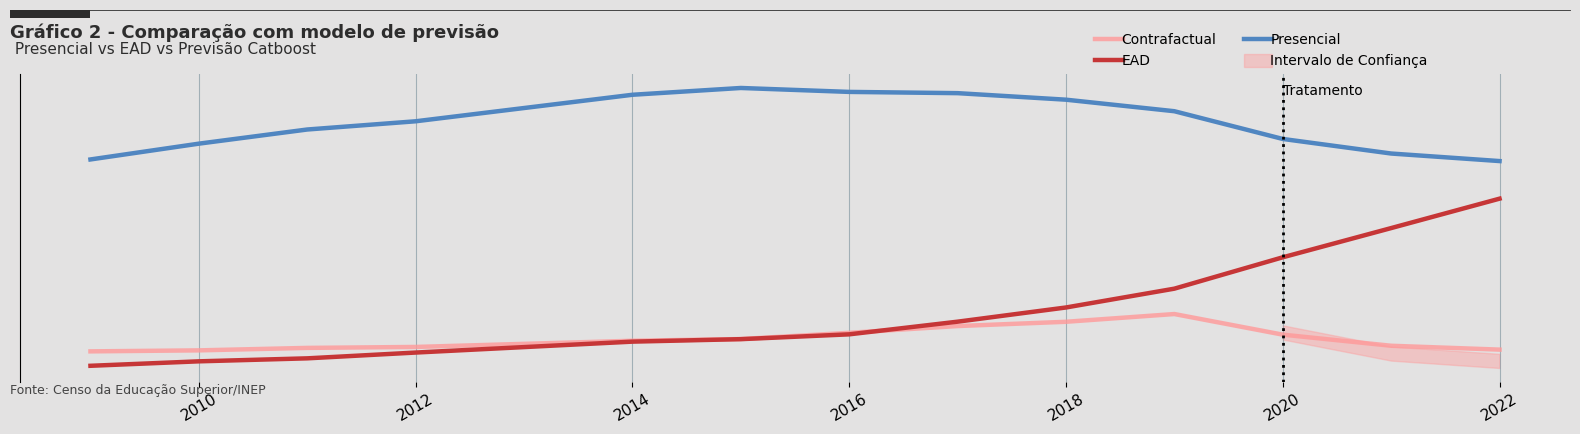

In [18]:
fig, ax = plt.subplots(figsize=(20,4), facecolor='#E3E2E2')

ax.grid(color='#758D99', alpha=0.6, zorder=1)

ax.set_facecolor('#E3E2E2')

ax.plot(base_causal['contrafactual'], color='#FF9999', alpha=0.8, linewidth=3.2)
ax.plot(base_causal['y'], color='#C63637', alpha=1.0, linewidth=3.2)
ax.plot(base_causal['PRESENCIAL'], color='#5086C1', alpha=1.0, linewidth=3.2)

plt.fill_between(base_causal.index, base_causal['post_preds_upper'], base_causal['post_preds_lower'], alpha=0.4, color='#FF9999', label='Intervalo de Confiança')

ax.axvline(x=2020, ls=':', c='black', lw=2), plt.text(2020, 6500000, s='Tratamento', c='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=11)        

ax.set_yticks(np.arange(0,10000,1000))
ax.set_yticklabels(np.arange(0, 10000, 1000),            
                   ha = 'right',                
                   verticalalignment='bottom')      

ax.yaxis.set_tick_params(pad=-2,             
                         labeltop=True,      
                         labelbottom=False,  
                         bottom=False,      
                         labelsize=11)      


ax.plot([0.12, .9],                  
        [1.04, 1.04],                 
        transform=fig.transFigure,   
        clip_on=False, 
        color='#2C2C2C', 
        linewidth=.6)

ax.add_patch(plt.Rectangle((0.12,1.04),                 
                           0.04,                 
                           -0.02,                      
                           facecolor='#2C2C2C', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

plt.xticks(rotation=30)

ax.text(x=0.12, y=0.97, s="Gráfico 2 - Comparação com modelo de previsão", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.93, s=" Presencial vs EAD vs Previsão Catboost", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

ax.legend(['Contrafactual', 'EAD', 'Presencial', 'Intervalo de Confiança'], loc=(.69,1.0), ncol=2, frameon=False, handletextpad=-.1, handleheight=1)

ax.text(x=0.12, y=0.08, s="""Fonte: Censo da Educação Superior/INEP """, transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show() 

O resultado da inferência causal indica que o lockdown gerou impacto nas matrículas de graduação em cursos EAD, já que o p-valor foi menor do 0.1, o que indica que há significância estatística.

Nos resultados do impacto causal vê-se que o efeito médio foi de 3,7 milhões de matrículas e o efeito acumulado de mais de 11 milhões de matrículas.

No Gráfico 2 vê-se que o distanciamento mais expressivo das linhas de matrículas nos cursos EAD e do contrafactual ocorre a patir do tratamento e que o observado fica fora do intervalo de confiança do previsto, o que indica que há significância estatística.